In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

K.clear_session() 

In [2]:
# Завантаження даних
X_train = np.load('preprocessed/X_train.npy')
y_train = np.load('preprocessed/y_train.npy')
X_val = np.load('preprocessed/X_val.npy')
y_val = np.load('preprocessed/y_val.npy')
X_test = np.load('preprocessed/X_test.npy')
y_test = np.load('preprocessed/y_test.npy')

In [3]:
# Завантаження маппінгу міток
with open('preprocessed/label_mapping.json', 'r') as f:
    label_data = json.load(f)
    gesture_mapping = {int(k): v for k, v in label_data['gesture_mapping'].items()}

# Визначення вибраних жестів
GESTURE_MAPPING = {
    0: "stop",
    1: "up",
    2: "down",
    3: "forward",
    5: "backward",
    4: "left",
    6: "right",
}
selected_labels = list(GESTURE_MAPPING.keys())

In [4]:
# Фільтрація даних для вибраних жестів
mask_train = np.isin(y_train, selected_labels)
X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]

mask_val = np.isin(y_val, selected_labels)
X_val_filtered = X_val[mask_val]
y_val_filtered = y_val[mask_val]

mask_test = np.isin(y_test, selected_labels)
X_test_filtered = X_test[mask_test]
y_test_filtered = y_test[mask_test]

In [5]:
# Перевірка балансу класів
print("\nРозподіл класів у тренувальному наборі:")
unique, counts = np.unique(y_train_filtered, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{GESTURE_MAPPING[label]}: {count} зразків")

# Перекодування міток у послідовні числа від 0 до 6
le = LabelEncoder()
le.fit(selected_labels)
y_train_encoded = le.transform(y_train_filtered)
y_val_encoded = le.transform(y_val_filtered)
y_test_encoded = le.transform(y_test_filtered)

# Оновлення назв класів
class_names = [GESTURE_MAPPING[label] for label in selected_labels]


Розподіл класів у тренувальному наборі:
stop: 2020 зразків
up: 1882 зразків
down: 1929 зразків
forward: 1952 зразків
left: 1981 зразків
backward: 1989 зразків
right: 2053 зразків


In [6]:
# Перевірка розмірів даних
print("\nРозміри даних:")
print(f"Тренувальні: {X_train_filtered.shape} з {len(np.unique(y_train_encoded))} класами")
print(f"Валідаційні: {X_val_filtered.shape}")
print(f"Тестові: {X_test_filtered.shape}")


Розміри даних:
Тренувальні: (13806, 128, 128, 1) з 7 класами
Валідаційні: (2959, 128, 128, 1)
Тестові: (2959, 128, 128, 1)


In [7]:
# Балансування класів
from sklearn.utils.class_weight import compute_class_weight

print("\nРозрахунок ваг класів для балансування...")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = dict(enumerate(class_weights))

print("Ваги класів:")
for class_id, weight in class_weights.items():
    print(f"Клас {class_names[class_id]}: {weight:.2f}")


Розрахунок ваг класів для балансування...
Ваги класів:
Клас stop: 0.98
Клас up: 1.05
Клас down: 1.02
Клас forward: 1.01
Клас backward: 1.00
Клас left: 0.99
Клас right: 0.96


In [8]:
def build_optimized_model(input_shape, num_classes):
    model = Sequential([
        # Перший згорточний блок
        Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Другий згорточний блок
        Conv2D(32, (4, 4), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Третій згорточний блок
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Flatten(),

        # Повнозв'язний шар
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Вихідний шар
        Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
# Компіляція моделі
input_shape = X_train_filtered.shape[1:]
num_classes = len(class_names)
model = build_optimized_model(input_shape, num_classes)

optimizer = Adam(learning_rate=0.00001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,126,279 (8.11 MB)

 Trainable params: 2,125,799 (8.11 MB)

 Non-trainable params: 480 (1.88 KB)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('optimized_gesture_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]


In [12]:
# Навчання моделі
print("\nПочаток навчання моделі...")
history = model.fit(
    X_train_filtered, y_train_encoded,
    validation_data=(X_val_filtered, y_val_encoded),
    epochs=80,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Початок навчання моделі...
Epoch 1/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4336 - loss: 1.8044

216/216 ━━━━━━━━━━━━━━━━━━━━ 46s 211ms/step - accuracy: 0.4338 - loss: 1.8040 - val_accuracy: 0.1771 - val_loss: 3.1455 - learning_rate: 1.0000e-05
Epoch 2/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5470 - loss: 1.4460

216/216 ━━━━━━━━━━━━━━━━━━━━ 45s 210ms/step - accuracy: 0.5470 - loss: 1.4458 - val_accuracy: 0.4485 - val_loss: 2.0988 - learning_rate: 1.0000e-05
Epoch 3/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6158 - loss: 1.2502

216/216 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.6159 - loss: 1.2501 - val_accuracy: 0.7540 - val_loss: 0.9304 - learning_rate: 1.0000e-05
Epoch 4/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6489 - loss: 1.1470

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.6489 - loss: 1.1468 - val_accuracy: 0.8317 - val_loss: 0.7464 - learning_rate: 1.0000e-05
Epoch 5/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6955 - loss: 1.0454

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.6955 - loss: 1.0454 - val_accuracy: 0.8489 - val_loss: 0.6759 - learning_rate: 1.0000e-05
Epoch 6/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7252 - loss: 0.9726

216/216 ━━━━━━━━━━━━━━━━━━━━ 44s 202ms/step - accuracy: 0.7252 - loss: 0.9726 - val_accuracy: 0.8594 - val_loss: 0.6568 - learning_rate: 1.0000e-05
Epoch 7/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7465 - loss: 0.9250

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.7465 - loss: 0.9249 - val_accuracy: 0.8621 - val_loss: 0.6278 - learning_rate: 1.0000e-05
Epoch 8/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7616 - loss: 0.8823

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.7616 - loss: 0.8822 - val_accuracy: 0.8743 - val_loss: 0.5968 - learning_rate: 1.0000e-05
Epoch 9/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7912 - loss: 0.8223

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.7912 - loss: 0.8223 - val_accuracy: 0.8790 - val_loss: 0.5670 - learning_rate: 1.0000e-05
Epoch 10/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.8021 - loss: 0.7838 - val_accuracy: 0.8773 - val_loss: 0.5289 - learning_rate: 1.0000e-05
Epoch 11/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8074 - loss: 0.7724

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.8074 - loss: 0.7723 - val_accuracy: 0.8794 - val_loss: 0.5274 - learning_rate: 1.0000e-05
Epoch 12/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8358 - loss: 0.7215

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step - accuracy: 0.8358 - loss: 0.7215 - val_accuracy: 0.8881 - val_loss: 0.4932 - learning_rate: 1.0000e-05
Epoch 13/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8470 - loss: 0.6913

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - accuracy: 0.8470 - loss: 0.6913 - val_accuracy: 0.8962 - val_loss: 0.4802 - learning_rate: 1.0000e-05
Epoch 14/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.8585 - loss: 0.6690 - val_accuracy: 0.8925 - val_loss: 0.4807 - learning_rate: 1.0000e-05
Epoch 15/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8643 - loss: 0.6476

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.8643 - loss: 0.6475 - val_accuracy: 0.9017 - val_loss: 0.4591 - learning_rate: 1.0000e-05
Epoch 16/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8672 - loss: 0.6408

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.8672 - loss: 0.6408 - val_accuracy: 0.9138 - val_loss: 0.4344 - learning_rate: 1.0000e-05
Epoch 17/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.8776 - loss: 0.6111 - val_accuracy: 0.9135 - val_loss: 0.4270 - learning_rate: 1.0000e-05
Epoch 18/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.8875 - loss: 0.5922 - val_accuracy: 0.9104 - val_loss: 0.4267 - learning_rate: 1.0000e-05
Epoch 19/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8938 - loss: 0.5776

216/216 ━━━━━━━━━━━━━━━━━━━━ 46s 212ms/step - accuracy: 0.8938 - loss: 0.5776 - val_accuracy: 0.9263 - val_loss: 0.3959 - learning_rate: 1.0000e-05
Epoch 20/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9026 - loss: 0.5489

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.9026 - loss: 0.5490 - val_accuracy: 0.9365 - val_loss: 0.3862 - learning_rate: 1.0000e-05
Epoch 21/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9012 - loss: 0.5482

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9012 - loss: 0.5482 - val_accuracy: 0.9388 - val_loss: 0.3884 - learning_rate: 1.0000e-05
Epoch 22/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9173 - loss: 0.5204

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.9172 - loss: 0.5204 - val_accuracy: 0.9436 - val_loss: 0.3735 - learning_rate: 1.0000e-05
Epoch 23/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9140 - loss: 0.5154

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9140 - loss: 0.5154 - val_accuracy: 0.9594 - val_loss: 0.3638 - learning_rate: 1.0000e-05
Epoch 24/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9212 - loss: 0.5033 - val_accuracy: 0.9527 - val_loss: 0.3669 - learning_rate: 1.0000e-05
Epoch 25/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9254 - loss: 0.4942

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9254 - loss: 0.4942 - val_accuracy: 0.9747 - val_loss: 0.3435 - learning_rate: 1.0000e-05
Epoch 26/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.9316 - loss: 0.4790 - val_accuracy: 0.9510 - val_loss: 0.3601 - learning_rate: 1.0000e-05
Epoch 27/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9316 - loss: 0.4738

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.9316 - loss: 0.4738 - val_accuracy: 0.9770 - val_loss: 0.3401 - learning_rate: 1.0000e-05
Epoch 28/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9375 - loss: 0.4586 - val_accuracy: 0.9686 - val_loss: 0.3401 - learning_rate: 1.0000e-05
Epoch 29/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9391 - loss: 0.4556

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9390 - loss: 0.4556 - val_accuracy: 0.9811 - val_loss: 0.3252 - learning_rate: 1.0000e-05
Epoch 30/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9430 - loss: 0.4453

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.9430 - loss: 0.4453 - val_accuracy: 0.9848 - val_loss: 0.3217 - learning_rate: 1.0000e-05
Epoch 31/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9394 - loss: 0.4419 - val_accuracy: 0.9787 - val_loss: 0.3229 - learning_rate: 1.0000e-05
Epoch 32/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9483 - loss: 0.4235 - val_accuracy: 0.9828 - val_loss: 0.3159 - learning_rate: 1.0000e-05
Epoch 33/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9477 - loss: 0.4264

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9477 - loss: 0.4264 - val_accuracy: 0.9865 - val_loss: 0.3063 - learning_rate: 1.0000e-05
Epoch 34/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9505 - loss: 0.4155

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.9505 - loss: 0.4155 - val_accuracy: 0.9885 - val_loss: 0.3061 - learning_rate: 1.0000e-05
Epoch 35/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9527 - loss: 0.4068 - val_accuracy: 0.9882 - val_loss: 0.3019 - learning_rate: 1.0000e-05
Epoch 36/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9593 - loss: 0.3978

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9593 - loss: 0.3978 - val_accuracy: 0.9895 - val_loss: 0.2953 - learning_rate: 1.0000e-05
Epoch 37/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9622 - loss: 0.3869

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.9622 - loss: 0.3869 - val_accuracy: 0.9916 - val_loss: 0.2912 - learning_rate: 1.0000e-05
Epoch 38/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9591 - loss: 0.3841 - val_accuracy: 0.9912 - val_loss: 0.2952 - learning_rate: 1.0000e-05
Epoch 39/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.9632 - loss: 0.3790 - val_accuracy: 0.9912 - val_loss: 0.2876 - learning_rate: 1.0000e-05
Epoch 40/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9657 - loss: 0.3730 - val_accuracy: 0.9902 - val_loss: 0.2832 - learning_rate: 1.0000e-05
Epoch 41/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9634 - loss: 0.3705 - val_accuracy: 0.9905 - val_loss: 0.2851 - learning_rate: 1.0000e-05
Epoch 42/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.9681 - loss: 0.3599 - val_accuracy: 0.9902 - val_loss: 0.2894 - learning_rate: 1.0000e-05
Epoch 43/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/st

216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9722 - loss: 0.3502 - val_accuracy: 0.9919 - val_loss: 0.2755 - learning_rate: 1.0000e-05
Epoch 44/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9698 - loss: 0.3548 - val_accuracy: 0.9912 - val_loss: 0.2825 - learning_rate: 1.0000e-05
Epoch 45/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.9743 - loss: 0.3439 - val_accuracy: 0.9916 - val_loss: 0.2715 - learning_rate: 1.0000e-05
Epoch 46/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9734 - loss: 0.3375 - val_accuracy: 0.9916 - val_loss: 0.2726 - learning_rate: 1.0000e-05
Epoch 47/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9713 - loss: 0.3393

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.9713 - loss: 0.3393 - val_accuracy: 0.9926 - val_loss: 0.2677 - learning_rate: 1.0000e-05
Epoch 48/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.9770 - loss: 0.3283 - val_accuracy: 0.9892 - val_loss: 0.2793 - learning_rate: 1.0000e-05
Epoch 49/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.9757 - loss: 0.3282 - val_accuracy: 0.9919 - val_loss: 0.2718 - learning_rate: 1.0000e-05
Epoch 50/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.9787 - loss: 0.3217 - val_accuracy: 0.9909 - val_loss: 0.2696 - learning_rate: 1.0000e-05
Epoch 51/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9786 - loss: 0.3179 - val_accuracy: 0.9909 - val_loss: 0.2712 - learning_rate: 1.0000e-05
Epoch 52/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.9819 - loss: 0.3161 - val_accuracy: 0.9919 - val_loss: 0.2635 - learning_rate: 1.0000e-05
Epoch 53/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/s

216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9917 - loss: 0.2582 - val_accuracy: 0.9929 - val_loss: 0.2437 - learning_rate: 2.0000e-06
Epoch 69/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.9892 - loss: 0.2617 - val_accuracy: 0.9919 - val_loss: 0.2429 - learning_rate: 2.0000e-06
Epoch 70/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9916 - loss: 0.2592 - val_accuracy: 0.9929 - val_loss: 0.2408 - learning_rate: 2.0000e-06
Epoch 71/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step - accuracy: 0.9922 - loss: 0.2557 - val_accuracy: 0.9929 - val_loss: 0.2419 - learning_rate: 2.0000e-06
Epoch 72/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 44s 203ms/step - accuracy: 0.9924 - loss: 0.2581 - val_accuracy: 0.9922 - val_loss: 0.2417 - learning_rate: 2.0000e-06
Epoch 73/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9925 - loss: 0.2563 - val_accuracy: 0.9926 - val_loss: 0.2407 - learning_rate: 2.0000e-06
Epoch 74/80
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/s

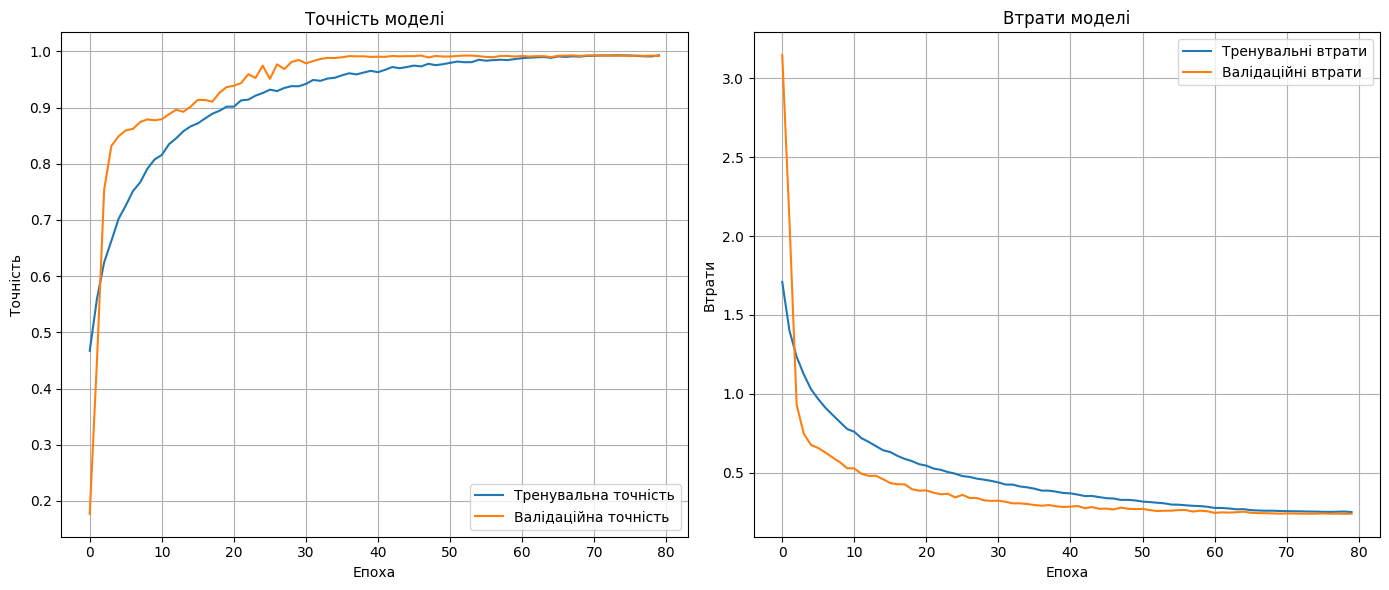

In [13]:
# Візуалізація результатів
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Тренувальна точність')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Точність моделі')
plt.ylabel('Точність')
plt.xlabel('Епоха')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Тренувальні втрати')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Втрати моделі')
plt.ylabel('Втрати')
plt.xlabel('Епоха')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('optimized_training_history.png')
plt.show()

In [14]:
# Оцінка на тестовому наборі
print("\nОцінка на тестових даних...")
test_loss, test_acc = model.evaluate(X_test_filtered, y_test_encoded, verbose=0)
print(f"Тестова точність: {test_acc:.4f}")
print(f"Тестові втрати: {test_loss:.4f}")


Оцінка на тестових даних...
Тестова точність: 0.9929
Тестові втрати: 0.2408


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


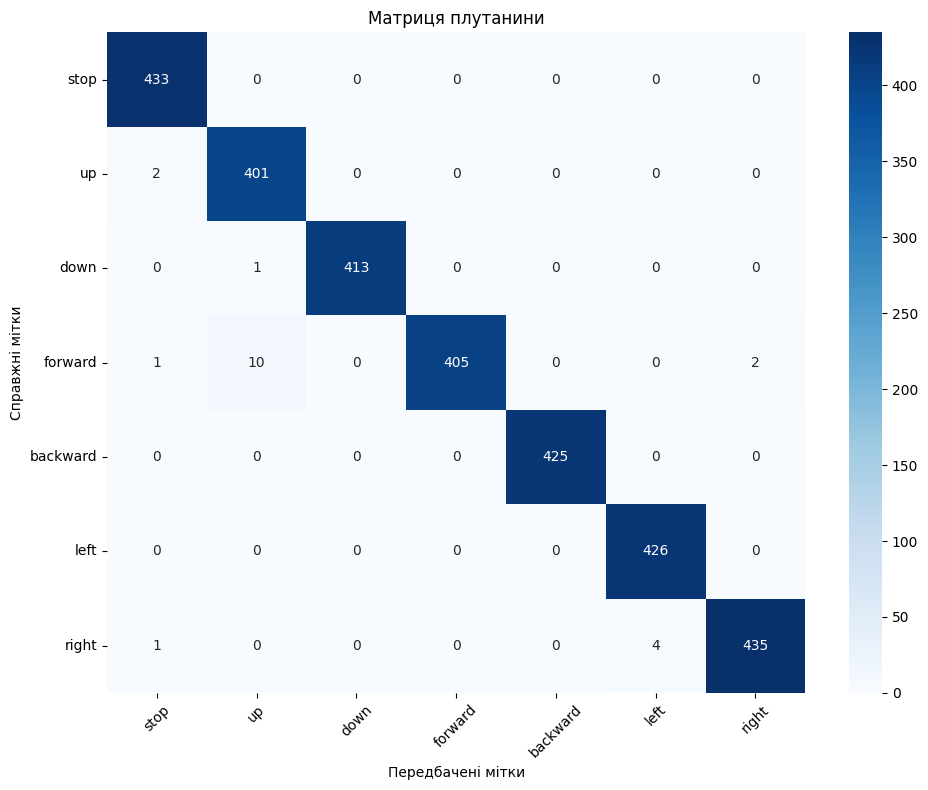

In [15]:
# Confusion Matrix
y_pred = model.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Матриця плутанини')
plt.xlabel('Передбачені мітки')
plt.ylabel('Справжні мітки')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('optimized_confusion_matrix.png')
plt.show()

In [16]:
# Classification report
print("\nЗвіт класифікації:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))



Звіт класифікації:
              precision    recall  f1-score   support

        stop       0.99      1.00      1.00       433
          up       0.97      1.00      0.98       403
        down       1.00      1.00      1.00       414
     forward       1.00      0.97      0.98       418
    backward       1.00      1.00      1.00       425
        left       0.99      1.00      1.00       426
       right       1.00      0.99      0.99       440

    accuracy                           0.99      2959
   macro avg       0.99      0.99      0.99      2959
weighted avg       0.99      0.99      0.99      2959



In [17]:
# Збереження моделі
model.save('optimized_gesture_model.h5')
print("\nМодель збережена як 'optimized_gesture_model.h5'")

# Аналіз результатів
val_acc = max(history.history['val_accuracy'])
print(f"\nНайкраща валідаційна точність: {val_acc:.4f}")
print(f"Тестова точність: {test_acc:.4f}")
print(f"Різниця: {abs(val_acc - test_acc):.4f}")


Модель збережена як 'optimized_gesture_model.h5'

Найкраща валідаційна точність: 0.9929
Тестова точність: 0.9929
Різниця: 0.0000
